# Multi-Perceptron Model: Experiments with CIFAR Dataset

TO DO: Put up a picture of a multi-perceptron model and explain what this two layer network

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import math
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) #Set default plot sizes
plt.rcParams['image.interpolation'] = 'nearest' #Use nearest neighbor for rendering

In [3]:
# Allowing notebooks to reload external python modules
# Details: http://stackoverflow.com/questions/1907993/aut
%load_ext autoreload
%autoreload 2

## Data Preparation
Use pickle to unpack to cifar data

In [4]:

def unpickle(file):
    fo = open(file, 'rb')
    data = pickle.load(fo, encoding = 'bytes')
    return data

## Importing the data

In [5]:
file = 'cifar/data_batch_1'
u = unpickle(file)

x = u[b'data'].reshape(10000,3,32,32).transpose(0,2,3,1).astype('float')
y = np.array(u[b'labels'])

## Visualize the data

In [6]:
classes = {"plane":0,'car':1,'bird':2,'cat':3,'deer':4,'dog':5,'frog':6,'horse':7,'ship':9,'truck':10}

In [7]:
def show_cifar_samples(x,y,class_of_interest):
        number_of_samples = 7
        idclass = classes[class_of_interest]
        y_sample = np.where(y == idclass)
        
        y_idx = y_sample[0][1:number_of_samples]
        offset = 1
        plt.figure(1)

        for i in y_idx:

            plt.subplot(number_of_samples,number_of_samples,offset)
            plt.imshow(x[i].astype('uint8'))
            if(offset == 1):
                plt.title(class_of_interest)
            offset= offset + 1
            plt.axis('off')

        plt.show()

        y_otherclass = np.where(y!=idclass)
        y_idx = y_otherclass[0][1:number_of_samples]

        offset = 1
        plt.figure(2)
        
        for i in y_idx:
            plt.subplot(number_of_samples,number_of_samples,offset)
            plt.imshow(x[i].astype('uint8'))
            if(offset == 1):
                plt.title("Other Class")
            offset= offset + 1
            plt.axis('off')

        plt.show()

In [8]:
def normalize(x):
        #Normalizing the vector
    mean_x = np.mean(x)
    stddev_x = np.std(x)
    x_output  = (x- mean_x) / stddev_x 
    
    return(x_output)

In [9]:
def generate_cifar_train_test_set(x, y, class_of_interest, show_samples = 0):
    if class_of_interest not in classes.keys():
        return("Errr")
    
    else:
        idclass = classes[class_of_interest]
        
        if show_samples:
            show_cifar_samples(x,y,class_of_interest)

        
        x_dataset = x
        y_dataset = np.zeros(len(y))
        y_dataset[y == idclass] = 1
        
        xtrain, xtest, ytrain, ytest = train_test_split(x_dataset, y_dataset, test_size = 0.2)
        x_train_vector = xtrain.reshape(xtrain.shape[0],-1).T
        x_test_vector = xtest.reshape(xtest.shape[0],-1).T
        
        x_train = normalize(x_train_vector)
        
        #For normalizing test data, we will use the mean and std.dev from the training data (i.e not the mean and std.dev
        # from the test data)
        mean_x = np.mean(x_train_vector)
        stddev_x = np.std(x_train_vector)
        x_test = (x_test_vector - mean_x)/stddev_x
        
        
        return(x_train,ytrain,x_test,ytest)

### Sigmoid

Exponential values for moderately large numbers tend to overflow. So np.clip is used here to limit the values of the signal between -500 and 500. Since e^x is between 0 and 1, the error in using this clip is low.Additionally, here I am using a numerically stable version of sigmoid function
Note that we can write 
$\frac{1}{1+e^-z}$ as $\frac{e^z}{1+e^z}$

In [10]:
import numpy as np
def sigmoid(x):
    x = np.clip(x, -500,500)
    if x.any()>=0:
        return 1/(1+ np.exp(-x))
    else:
        return np.exp(x)/(1 + np.exp(x))

### Initialize Parameters

In [11]:
def init_parameters(dim1, dim2=1,std=1e-1, random = True):
    if(random):
        return(np.random.random([dim1,dim2])*std)
    else:
        return(np.zeros([dim1,dim2]))

### Forward Propogation

Here, I am assuming a single layered network. Note that event with single layered network, the layer itself can have multiple nodes. Also, I am using vectorized operations here i.e not using explicit loops. This helps in processing multiple inputs.

In [23]:
#Two layer network: Forward Prop
def fwd_prop(W1,B1,W2,B2,X,Y):
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]
    n_2 = np.shape(W2)[0]
    #print("n_0:",n_0)
    #print("m:",m)
    #print("n_1",n_1)
    
    #Dimensions
    # X = (n_0,m)
    # W1 = (n_1,n_0)
    # B1 = (n_1,1) -> Broadcast -> (n_1,m)
    # Z1 = (n_1,m)
    # A1 = (n_1,m)
    Z1 = np.dot(W1,X) + B1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2,A1) + B2
    A2 = sigmoid(Z2)
    #print("A1 shape", np.shape(A1))
    return(A2,A1)

In [25]:
#Single layer network: Backprop

def back_prop(A1,W1,B1,A2,W2,B2,X,Y):
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]
    n_2 = np.shape(W2)[0] #Note n_2 = 1 because the the final output generates 1 value for each input datapoint
      
    cost = (-1/m)*np.sum(Y*np.log(A2) + (1-Y)*np.log(1-A2))
    
    #shape(dA2) = shape(A2) = (n_2,m)->(1,m)
    dA2 = -Y/A2 + (1-Y)/(1-A2) # (Y) -> (1,m) & (A2) -> (1,m) hence whole eqn = (1,m)
    
    #shape(dZ2) = shape(Z2) = (n_2,m) ->(1,m)
    dZ2 = (1/m)*(A2 - Y)
    
    #shape(dW2) = shape(W2) = (n_2,n_1) = (1,n_1)
    #Note that (1/m) factor is taken care of in the calculation of dZ2
    
    dW2 = np.dot(dZ2, A1.T) # (dZ2) = (n_2,m), A1 ->(n_1,m)
                                    # Hence result shape = (n_2,n_1) = (1,n_1)
    
    #shape(dB2) = shape(B2) = (n_2,1) = (1,1)
    dB2 = (1/m) * np.sum(dZ2, axis = 1, keepdims = True) 
    
    #(A1) = (n_1,m)
    dA1 = np.dot(W2.T,dZ2) #(dZ2) = (n_2,m), (W2) = (n_2,n_1) hence dot product of W2.T and dZ2 gives correct op
    
    #(Z1) = (n_1,m)
    dZ1 = dA1*(A1)*(1-A1) #(dA1) = (n_1,m), (A1) = (n_1,m), hence elementwise product for preserving dimensions
    
    #(W1) = (n_1,n_0) hence (dW1) = (n_1,n_0)
    dW1 = np.dot(dZ1, X.T) #(dZ1) = (n_1,m); (X) = (n_0,m) hence dot product(dZ1,X.T) = (n_1,n_0)
    
    #(B1) = (n_1,1) which gets broadcasted to (n_1,m); hence (dB1) = (n_1,1)
    dB1 = np.sum(dZ1, axis = 1, keepdims = True) #(dZ1) = (n_1,m) so sum along all the rows to get (n_1,1)
    
    grads ={"dW2": dW2, "dB2":dB2,"dW1": dW1, "dB1":dB1}
    
    return(grads,cost)

In [22]:
def run_grad_desc(num_iterations, learning_rate,X,Y,n_1,n_2 = 1):
    n_0, m = np.shape(X)
    
    W1 = init_parameters(n_1, n_0, random= False)
    B1 = init_parameters(n_1,1, random = False)
    
    W2 = init_parameters(n_2, n_1, random= False)
    B2 = init_parameters(n_2,1, random = False)
    
    loss_array = np.ones([num_iterations])*np.nan
    for i in np.arange(num_iterations):
        A2,A1 = fwd_prop(W1,B1,W2,B2,X,Y)
        grads,cost = back_prop(A1,W1,B1,A2,W2,B2,X,Y)
        
        W1 = W1 - learning_rate*grads["dW1"]
        B1 = B1 - learning_rate*grads["dB1"]
        W2 = W2 - learning_rate*grads["dW2"]
        B1 = B2 - learning_rate*grads["dB2"]

        loss_array[i] = cost
        
        parameter = {"W1":W1,"B1":B1,"W2":W2,"B2":B2}
    
    return(parameter,loss_array)

In [20]:
x_train, y_train, x_test, y_test = generate_cifar_train_test_set(x, y, "deer", show_samples = 0)

In [27]:
#Lets test on the CIFAR dataset
params, loss_array = run_grad_desc(3000,0.005,x_train, y_train, n_1 = 5, n_2 = 1)
#Training data accuracy

In [30]:
y_train_predict,A1 = fwd_prop(params["W1"],params["B1"],params["W2"],params["B2"],x_train,y_train)
y_train_predict[y_train_predict>=0.5] = 1
y_train_predict[y_train_predict< 0.5] = 0
accuracy = np.sum(y_train_predict == y_train)/len(y_train)
accuracy

0.89975000000000005

In [31]:
#Test data accuracy
y_predict,A1 = fwd_prop(params["W1"],params["B1"],params["W2"],params["B2"],x_test,y_test)
y_predict[y_predict>=0.5] = 1
y_predict[y_predict< 0.5] = 0
accuracy = np.sum(y_predict == y_test)/len(y_test)
accuracy

0.90149999999999997

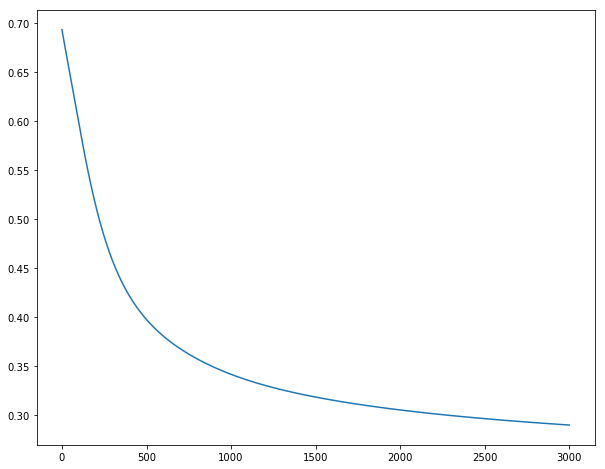

In [32]:
plt.plot(loss_array)